Humans are said to have unique gaits.<br>
Testing out the process developed for animals on humans.<br>
Using mediapipe to detect the keypoints of the human body.<br>

In [1]:
# import mediapipe as mp
# from mediapipe.tasks import python
# from mediapipe.tasks.python import vision
# import os
# from pathlib import Path
# # model_path = os.path.join(os.getcwd(), 'models', 'pose_landmarker_heavy.task')
# # import mediapipe as mp

# # BaseOptions = mp.tasks.BaseOptions
# # PoseLandmarker = mp.tasks.vision.PoseLandmarker
# # PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
# # PoseLandmarkerResult = mp.tasks.vision.PoseLandmarkerResult
# # VisionRunningMode = mp.tasks.vision.RunningMode

# # # Create a pose landmarker instance with the live stream mode:
# # def print_result(result: PoseLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
# #     print('pose landmarker result: {}'.format(result))

# # options = PoseLandmarkerOptions(
# #     base_options=BaseOptions(model_asset_path=model_path),
# #     running_mode=VisionRunningMode.LIVE_STREAM,
# #     result_callback=print_result)

# # # with PoseLandmarker.create_from_options(options) as landmarker:
  

Using Normalized x and y coordinates for the landmarks and the visibility above 0.7 as present.<br>
If the visibility is below 0.7, the landmark is considered absent.<br>
A future look might be to use a certain z coordinate if beyond a certain depth to be considered absent.<br>
Currently only store x and y coordinates.<br>

In [91]:
import mediapipe as mp
import cv2
import pandas as pd
import datetime
import os
import json
import matplotlib.pyplot as plt
import json
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP


# Define mp_drawing and mp_pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Create an instance of the Pose class
pose = mp.solutions.pose.Pose()

# labels
labels_map = {no: i.name for no, i in enumerate(mp_pose.PoseLandmark)}

# load the pose graph
with open('pose_graph.json') as f:
    pose_graph = json.load(f) 

In [95]:
time_nows = []

In [97]:
# Use OpenCV’s VideoCapture to start capturing from the webcam.
cap = cv2.VideoCapture(0)

# Create a window
cv2.namedWindow('MediaPipe Pose', cv2.WINDOW_NORMAL)

# Resize the window
cv2.resizeWindow('MediaPipe Pose', 800, 600)

frame_count = 0
landmarks_dict = dict()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

# Create a loop to read the latest frame from the camera using VideoCapture#read()
# and convert the frame to a format that can be processed by MediaPipe.
while cap.isOpened():
    success, image = cap.read()

    # count the framerate to write the video at the same framerate
    framerate = cap.get(cv2.CAP_PROP_FPS)
    # get the width and height of the frame
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # print(f'framerate: {framerate}, width: {width}, height: {height}')

    if not success:
        print("Ignoring empty camera frame.")
        # If loading a video, use 'break' instead of 'continue'.
        continue
    # print(frame_count)

    # Convert the BGR image to RGB and process it with MediaPipe Pose.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Convert the landmarks to a list of dictionaries
    if results.pose_landmarks is not None:
        # Convert the landmarks to a list of dictionaries
        if results.pose_landmarks is not None:
            landmarks = {labels_map[i]: {'x': landmark.x, 'y': landmark.y, 'visibility': 1 if landmark.visibility > 0.7 else 0} 
                         for i, landmark in enumerate(results.pose_landmarks.landmark)}
        else:
            landmarks = None
    else:
        landmarks = None

    landmarks_dict[f'landmarks_{frame_count}'] = landmarks

    # Draw pose landmarks on the image.
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2.imshow('MediaPipe Pose', annotated_image)

    # Write the frame to the video
    out.write(annotated_image)

    if cv2.waitKey(5) & 0xFF == ord('q'):
        # Save the landmarks to a JSON file 
        if not os.path.exists('landmarks'):
            os.mkdir('landmarks')
        # write the landmarks dict to a JSON file with the current timestamp
        time_now = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        with open(f'landmarks/landmarks_{time_now}.json', 'w') as f:
            json.dump(landmarks_dict, f, indent=4)
        
        if not os.path.exists('video'):
            os.mkdir('video')
        # Save the video with the current timestamp
        video_name = f'video/video_{time_now}.avi'
        out.release()
        os.rename('output.avi', video_name)
        break

    frame_count += 1

cap.release()
cv2.destroyAllWindows()


In [98]:
# append time_now to a list for referencing the files experimenting session lost during notebook restart
time_nows.append(time_now)
time_nows

['20240302131846', '20240302131953']

In [99]:
# Load the landmarks from the JSON file
landmarks_file = os.path.join(os.getcwd(), f'landmarks\landmarks_{time_nows[0]}.json')

with open(landmarks_file) as f:
    landmarks = json.load(f)

In [100]:
def mediapipe_pose_graph(landmarks: dict, pose_graph: dict, draw: bool = False):
    """
    Create a graph from the landmarks and the pose graph
    """
    # if null landmarks, return None
    if landmarks is None:
        return 
    # Initialize a new graph
    G = nx.Graph()

    node_positions = {k: (v['x'], v['y']) for k, v in landmarks.items()}

    # Add nodes with positions and existence probability
    for node, coord_prob in landmarks.items():
        x, y = coord_prob['x'], coord_prob['y']
        G.add_node(node, pos=(x, y), probability=coord_prob['visibility'])

    # Add edges with weights
    for node, neighbors in pose_graph.items():
        for neighbor in neighbors:
            x1, y1 = landmarks[node]['x'], landmarks[node]['y']
            x2, y2 = landmarks[neighbor]['x'], landmarks[neighbor]['y']
            weight = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
            G.add_edge(node, neighbor, weight=weight)

    # Draw the graph
    if draw:
        nx.draw(G, pos=node_positions, with_labels=True, node_size=100, node_color='lightblue', font_size=8)
        plt.show()

    return G

# G = nx.Graph()

graph = mediapipe_pose_graph(landmarks['landmarks_30'], pose_graph, draw=False)
graph_ref = mediapipe_pose_graph(landmarks['landmarks_200'], pose_graph, draw=False)

# store the values of the entire file
landmarks_frames = [
        nx.to_numpy_matrix(mediapipe_pose_graph(landmarks[f'landmarks_{i}'], pose_graph, draw=False))
        for i in range(len(landmarks)) if landmarks[f'landmarks_{i}']
        ]

c:\Users\Austin\Desktop\Agent\animal-pose-estimation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


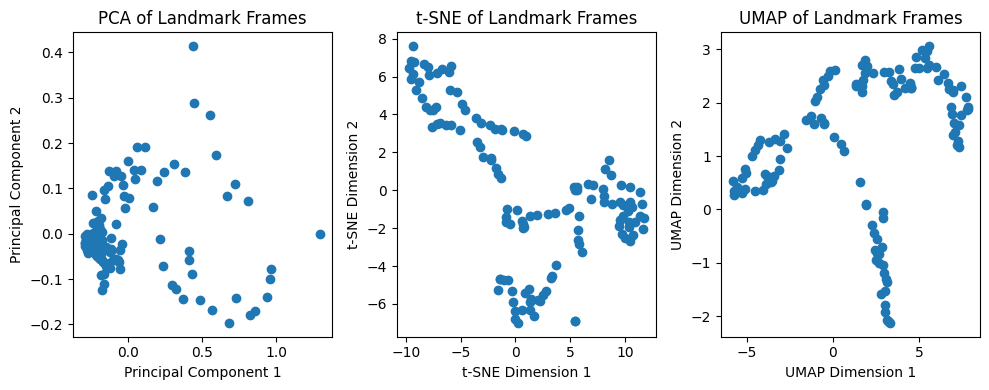

In [75]:

# Convert the list of landmark frames to a numpy array
landmark_frames_array = np.array(landmarks_frames)

# Reshape the array to 2D
landmark_frames_2d = landmark_frames_array.reshape(landmark_frames_array.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(landmark_frames_2d)

# Apply t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(landmark_frames_2d)

# Apply UMAP
umap = UMAP(n_components=2)
umap_result = umap.fit_transform(landmark_frames_2d)

# Plot the PCA result
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Landmark Frames')

# Plot the t-SNE result
plt.subplot(1, 3, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE of Landmark Frames')

# Plot the UMAP result
plt.subplot(1, 3, 3)
plt.scatter(umap_result[:, 0], umap_result[:, 1])
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP of Landmark Frames')

plt.tight_layout()
plt.show()


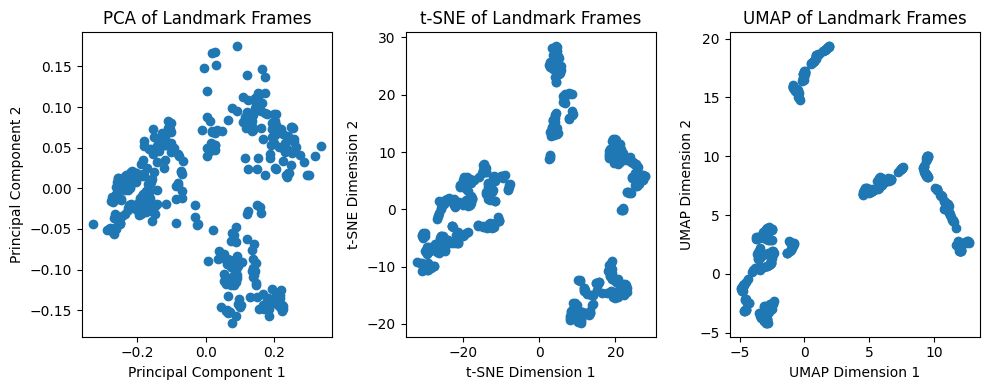

In [89]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Convert the list of landmark frames to a numpy array
landmark_frames_array = np.array(landmarks_frames)

# Reshape the array to 2D
landmark_frames_2d = landmark_frames_array.reshape(landmark_frames_array.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(landmark_frames_2d)

# Apply t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(landmark_frames_2d)

# Apply UMAP
umap = UMAP(n_components=2)
umap_result = umap.fit_transform(landmark_frames_2d)

# Plot the PCA result
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Landmark Frames')

# Plot the t-SNE result
plt.subplot(1, 3, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE of Landmark Frames')

# Plot the UMAP result
plt.subplot(1, 3, 3)
plt.scatter(umap_result[:, 0], umap_result[:, 1])
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP of Landmark Frames')

plt.tight_layout()
plt.show()


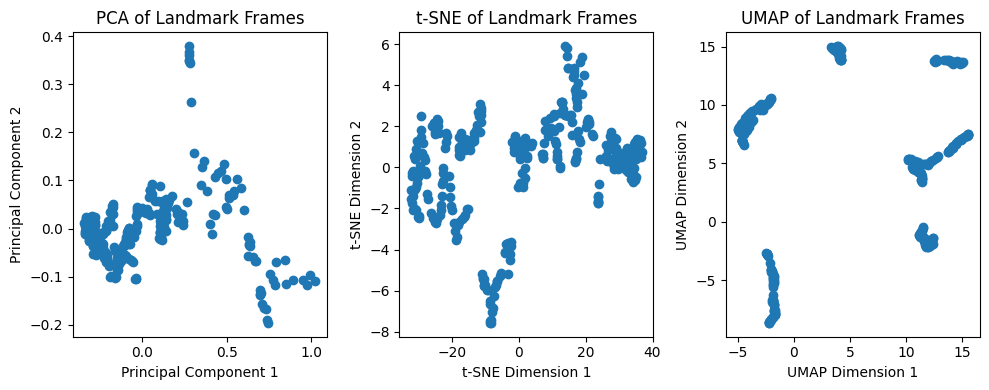

In [101]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Convert the list of landmark frames to a numpy array
landmark_frames_array = np.array(landmarks_frames)

# Reshape the array to 2D
landmark_frames_2d = landmark_frames_array.reshape(landmark_frames_array.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(landmark_frames_2d)

# Apply t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(landmark_frames_2d)

# Apply UMAP
umap = UMAP(n_components=2)
umap_result = umap.fit_transform(landmark_frames_2d)

# Plot the PCA result
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Landmark Frames')

# Plot the t-SNE result
plt.subplot(1, 3, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE of Landmark Frames')

# Plot the UMAP result
plt.subplot(1, 3, 3)
plt.scatter(umap_result[:, 0], umap_result[:, 1])
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP of Landmark Frames')

plt.tight_layout()
plt.show()


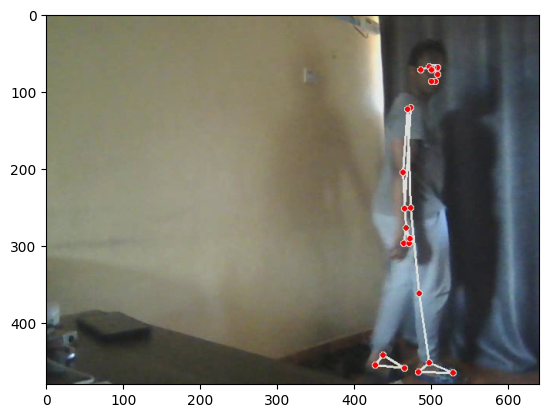

In [103]:
import cv2

def display_frame_at_frame_count(frame_count, file_no):
    # Load the video
    video_file = os.path.join(os.getcwd(), 'video', f'video_{file_no}.avi')

    # Define the framerate
    framerate = 30

    cap = cv2.VideoCapture(video_file)

    # Set the frame position to the desired point
    frame_position = int(frame_count / framerate * cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_position)

    # Read the frame at the desired point
    success, frame = cap.read()
    if not success:
        print('Error reading the video file')
        return

    # Display the frame with matplotlib
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

# Call the function with the desired frame count
display_frame_at_frame_count(2, time_nows[0])



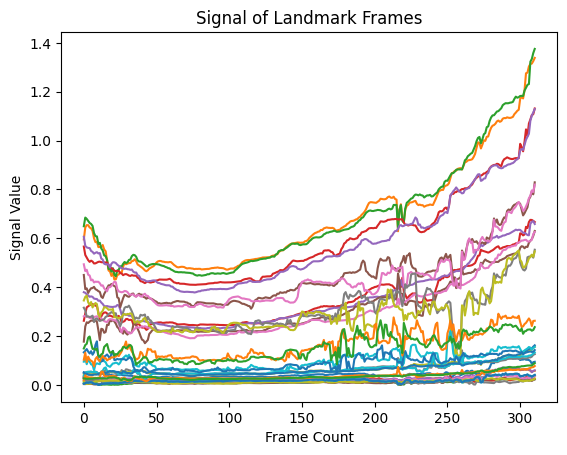

In [110]:
# generate a signal
signal = np.sum(landmark_frames_array, axis=1)

# plot the signal
plt.plot(signal)
plt.xlabel('Frame Count')
plt.ylabel('Signal Value')
plt.title('Signal of Landmark Frames')
plt.show()


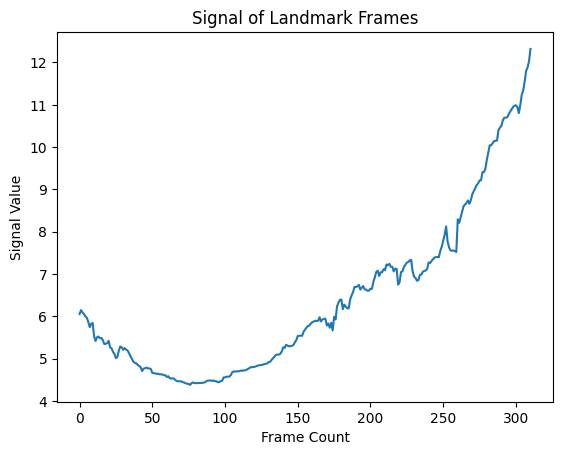

In [112]:
# generate a signal
signal = np.sum(landmark_frames_array, axis=(1, 2))

# plot the signal
plt.plot(signal)
plt.xlabel('Frame Count')
plt.ylabel('Signal Value')
plt.title('Signal of Landmark Frames')
plt.show()


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pygsp as pg

G = pg.graphs.Sensor(seed=42)
G.compute_fourier_basis()

scales = [10, 3, 0]
limit = 0.44

fig, axes = plt.subplots(2, len(scales), figsize=(12, 4))
fig.subplots_adjust(hspace=0.5)

x0 = np.random.default_rng(1).normal(size=G.N)
for i, scale in enumerate(scales):
    g = pg.filters.Heat(G, scale)
    x = g.filter(x0).squeeze()
    x /= np.linalg.norm(x)
    x_hat = G.gft(x).squeeze()

    assert np.all((-limit < x) & (x < limit))
    G.plot(x, limits=[-limit, limit], ax=axes[0, i])
    axes[0, i].set_axis_off()
    axes[0, i].set_title('$x^T L x = {:.2f}$'.format(G.dirichlet_energy(x)))

    axes[1, i].plot(G.e, np.abs(x_hat), '.-')
    axes[1, i].set_xticks(range(0, 16, 4))
    axes[1, i].set_xlabel(r'graph frequency $\lambda$')
    axes[1, i].set_ylim(-0.05, 0.95)

axes[1, 0].set_ylabel(r'frequency content $\hat{x}(\lambda)$')

# axes[0, 0].set_title(r'$x$: signal in the vertex domain')
# axes[1, 0].set_title(r'$\hat{x}$: signal in the spectral domain')

fig.tight_layout()

In [ ]:
import numpy as np
import networkx as nx
from scipy.linalg import eigh

def graph_fourier_transform(G):
    """
    Compute the Graph Fourier Transform (GFT) of a graph G.

    Parameters:
    - G: NetworkX graph

    Returns:
    - gft_matrix: Matrix containing the Graph Fourier Transform coefficients
    """
    # Adjacency matrix
    A = nx.adjacency_matrix(G).toarray()

    # Degree matrix
    D = np.diag(np.sum(A, axis=1))

    # Laplacian matrix
    L = D - A

    # Eigen decomposition of the Laplacian matrix
    eigenvalues, eigenvectors = eigh(L)

    # Reorder eigenvalues and eigenvectors
    idx = eigenvalues.argsort()
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Compute the Graph Fourier Transform matrix
    gft_matrix = eigenvectors.T

    return gft_matrix

def alter_eigenvectors(eigenvectors, scale):
    """
    Alter the eigenvectors of a graph by scaling them.

    Parameters:
    - eigenvectors: Eigenvectors matrix
    - scale: Scaling factor

    Returns:
    - altered_eigenvectors: Altered eigenvectors matrix
    """
    altered_eigenvectors = eigenvectors * scale
    return altered_eigenvectors

# Example graph
G = nx.path_graph(5)

# Compute Graph Fourier Transform
gft_matrix = graph_fourier_transform(G)

# Alter the eigenvectors
scaled_gft_matrix = alter_eigenvectors(gft_matrix, 2.0)

# Print the altered Graph Fourier Transform matrix
print("Altered GFT Matrix:")
print(scaled_gft_matrix)


In [ ]:
import networkx as nx
import numpy as np
from pygsp import graphs, filters

# Step 1: Construct your Pose Graph using NetworkX
G = nx.Graph()
# Add nodes and edges to G representing your pose graph

# Step 2: Compute Laplacian Matrix
L = nx.linalg.laplacian_matrix(G).todense()

# Step 3: Apply Graph Fourier Transform
graph = graphs.Graph(L)
graph.compute_fourier_basis()
# Now you can access graph.U (the eigenvectors) and graph.e (the corresponding eigenvalues)

# Example: Print the first few eigenvalues
print("Eigenvalues:", graph.e[:5])

# Example: Plot the first few eigenvectors
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    axes.flat[i].plot(graph.U[:, i])
    axes.flat[i].set_title(f'Eigenvector {i}')
plt.show()


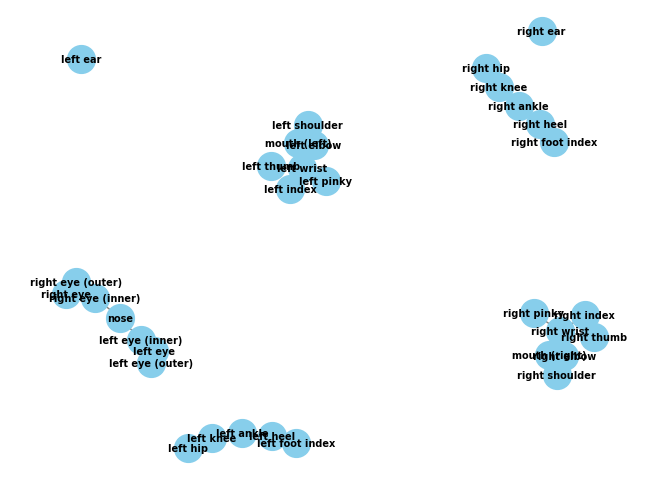

In [ ]:
import networkx as nx

G = nx.Graph(graph)

nx.draw(G, with_labels=True, font_weight='bold', node_size=400,
        node_color='skyblue', font_color='black', font_size=7, edge_color='grey')

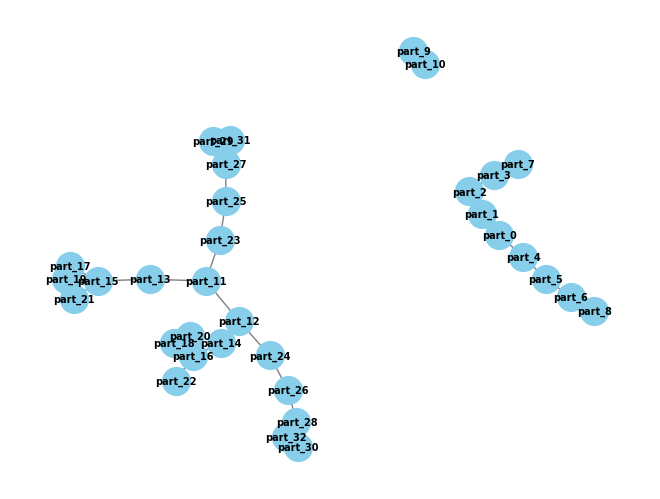

In [23]:
import networkx as nx

# Create the pose graph
G = nx.Graph(pose_graph)

# visualize the graph
nx.draw(G, with_labels=True, font_weight='bold', node_size=400,
        node_color='skyblue', font_color='black', font_size=7, edge_color='grey')


In [14]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting


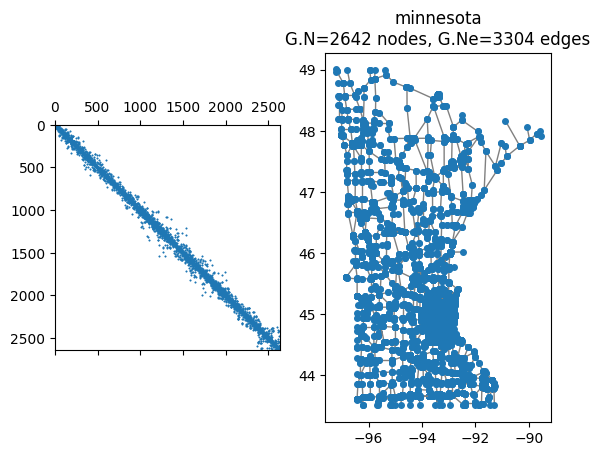

In [19]:
G = graphs.Minnesota()
G.coords.shape # coordinates are already set for nodes for visualisation
fig, axes = plt.subplots(1, 2)
_ = axes[0].spy(G.W, markersize=0.5) #visualise the adjacency matrix in a spy plot
G.plot(ax=axes[1]) # visualise the graph in 2D coordinates


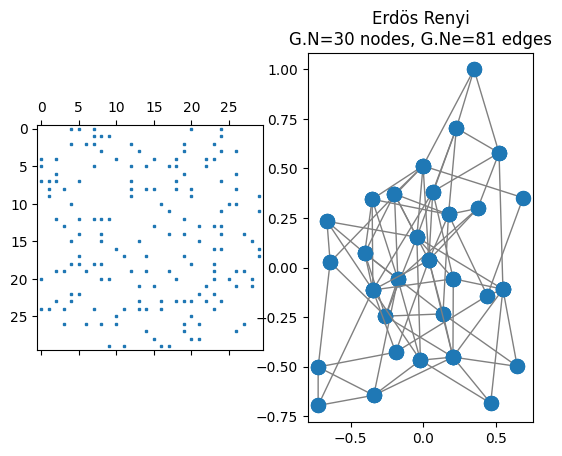

In [18]:
G = graphs.ErdosRenyi(N=30, p=0.2)
G.set_coordinates(kind='spring') # set coordinates for nodes for visualisation
fig, axes = plt.subplots(1, 2)
_ = axes[0].spy(G.W, markersize=2)
G.plot(ax=axes[1])


In [27]:
# convert the pose_graph networkx(G) graph to a pygsp graph
A = nx.adjacency_matrix(G)
G = graphs.Graph(A)

C:\Users\Austin\AppData\Local\Temp\ipykernel_36512\1479713980.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


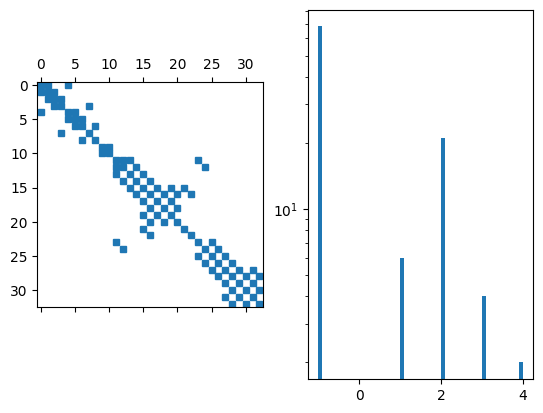

In [28]:
G.compute_laplacian('combinatorial')
fig, axes = plt.subplots(1, 2)
axes[0].spy(G.L, markersize=5)
axes[1].hist(G.L.data, bins=50, log=True);


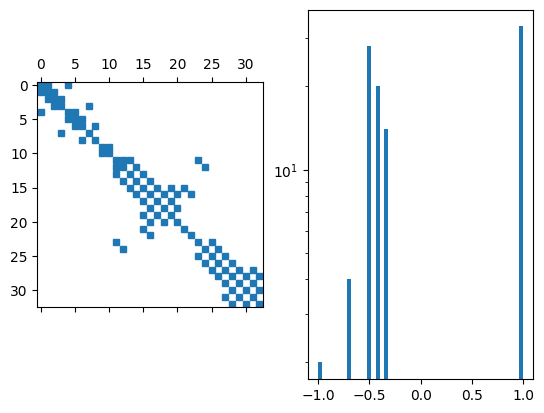

In [30]:
# compute the normalized Laplacian
G.compute_laplacian('normalized')
G.compute_fourier_basis()
fig, axes = plt.subplots(1, 2)
axes[0].spy(G.L, markersize=5)
axes[1].hist(G.L.data, bins=50, log=True);


AttributeError: Graph has no coordinate set. Please run G.set_coordinates() first.

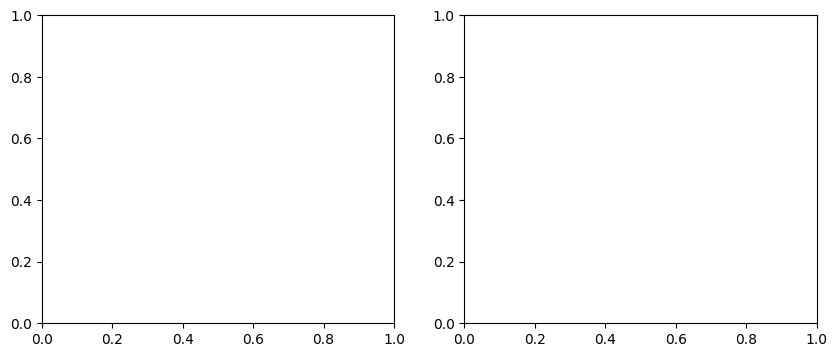

In [32]:
G.compute_fourier_basis()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G.plot_signal(G.U[:, 2], vertex_size=50, ax=axes[0]) # the 3rd eigenvector as a signal on the graph
G.set_coordinates('line1D')
G.plot_signal(G.U[:, 0:3], ax=axes[1]) # the first three eigenvectors on the real line
fig.tight_layout()
